# Automatic data labeling with snorkel-metal

John Brandt


Last Updated: August 15, 2019

## Loading and preprocessing data

In [109]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import re
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import confusion_matrix, f1_score

from metal.label_model import LabelModel
from metal.analysis import lf_summary, label_coverage
from metal.label_model.baselines import MajorityLabelVoter
import nltk
nltk.download('wordnet')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/john.brandt/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [110]:
df = pd.read_csv("../data/processed/gold_standard.csv")

#df['class'] = df['class'].map({'n' : 1, 'd' : 2, 'i' : 3})
df['class'][df['class'].isna()] = 1
df.head(5)

/Users/john.brandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,label,sentences,class
0,0,the purpose of the middle level institutions i...,1.0
1,1,"to address these challenges, the government wi...",1.0
2,2,lack of a database and information to support ...,3.0
3,3,to contribute to efforts to reduce poverty and...,3.0
4,4,secretariat. its terms of reference will inclu...,1.0


In [111]:
# currently gold standard has been validated up to sample 80
#df['class'] = df['class'].map({1.0 : 'n', 3 : 'i', 2: 'd'})
#for i in range(50, 52):
#    print(i, df['class'][i], '\t', df['sentences'][i], '\n')

In [112]:
# disincentive -> contains finance words and a negative sentiment
# "offer financial services"
# "supporting innovation"
to_update = {6: 'i', 21: 'i', 26: 'i',
            27: 'i', 31: 'i',
            42: 'i', 50: 'i',
            }

## Creating labeling functions

In [167]:
ABSTAIN = 0
NEUTRAL = 1
NEGATIVE = 2
POSITIVE = 3

from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
ps = SnowballStemmer('english')


def ngram_index(words, ngram):
    try:
        return list(nltk.ngrams(words, len(ngram))).index(tuple(ngram))
    except:
        return None


def split_and_search(string, l1, l2, stem = True):
    string = tokenizer.tokenize(string)
    
    if stem:
        string = [ps.stem(x) for x in string]
        stem1 = []
        stem2 = []
        for x, val in enumerate(l1):
            ls = val.split(' ')
            stem1.append(' '.join([ps.stem(x) for x in ls]))
        for x, val in enumerate(l2):
            ls = val.split(' ')
            stem2.append(' '.join([ps.stem(x) for x in ls]))

    list1 = [ngram_index(string, a.split(' ')) for a in stem1]
    list2 = [ngram_index(string, a.split(' ')) for a in stem2]  

    loc1 = [x for x in list1 if x != None]
    loc2 = [x for x in list2 if x != None]

    if loc1 and loc2:
        min_diff = min([abs(x - y) for x, y in zip(sorted(loc1), sorted(loc2))])
        return min_diff
    else:
        return 999

### Positive

In [168]:
# x budgets, x finance, x funds, x financial incentives
implementing = ['improve', 'provide', 'establish', 'implement', 'assist', 'raise', 'facilitate',
                'increase', 'offer', 'earmark', 'obtain', 'access', 'aid', 'promote', 'found',
               'create', 'initiate']

# passive format
passive = ['will be']

# x budgets, x finance, x funds, x financial incentives, base
encouraging = ['encourage', 'assist', 'mobilize', 'motivate', 'stimulate', 'support', 'endorse', 'recommend',
               'strengthen', 'foster', 'prompt']

base_words = ['fund', 'investment', 'finance', 'credit', 'budget', 'resource']

budgets = ['allocation', 'allocate', 'budget', 'financial', 'financing commitment', 'increase resource allocation',
          'will be financed', 'delivery of financial', 'resource']

finance = ['microfinance', 'institutional finance', 'concessional finance', 'bilateral finance', 'micro finance',
           'results based finance', 'philanthropic finance', 'multilateral finance', 'financing commitment',
          'international finance', 'private sector finance', 'financial mechanism']

funds = ['capital', 'concessional', 'results based', 'carbon market', 'grant fund', 'youth enterprise fund',
        'devolution fund', 'green climate fund', 'development fund', 'adequate fund', 'devolved fund',
        'revolving fund', 'financial mechanism', 'devolution fund']

financial_incentives = ['payment for', 'results based', 'tax break', 'tax incentive', 'financial incentive',
                       'access to credit', 'taxation incentive']

specific_incentives = ['market connection', 'low transaction cost', 'credit package', 'carbon credit',
                      'transfer pricing', 'access to finance', 'market access',' access of',' new investment',
                      'green growth','tax free']

# barrier_reduction = ['reduce cost']

In [169]:
## ENCOURAGING - BUDGET
def implementing_x_budget_5(text):
    diff = split_and_search(text, l1 = implementing, l2 = budgets)
    return POSITIVE if diff < 5 else ABSTAIN

def implementing_x_budget_10(text):
    diff = split_and_search(text, l1 = implementing, l2 = budgets)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FINANCE
def implementing_x_finance_5(text):
    diff = split_and_search(text, l1 = implementing, l2 = finance)
    return POSITIVE if diff < 5 else ABSTAIN

def implementing_x_finance_10(text):
    diff = split_and_search(text, l1 = implementing, l2 = finance)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FUNDS
def implementing_x_funds_5(text):
    diff = split_and_search(text, l1 = implementing, l2 = funds)
    return POSITIVE if diff < 5 else ABSTAIN

def implementing_x_funds_10(text):
    diff = split_and_search(text, l1 = implementing, l2 = funds)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FINANCIAL INCENTIVES
def implementing_x_incentive_5(text):
    diff = split_and_search(text, l1 = implementing, l2 = financial_incentives)
    return POSITIVE if diff < 5 else ABSTAIN

def implementing_x_incentive_10(text):
    diff = split_and_search(text, l1 = implementing, l2 = financial_incentives)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - BASE
def implementing_x_base_5(text):
    diff = split_and_search(text, l1 = implementing, l2 = base_words)
    return POSITIVE if diff < 5 else ABSTAIN

def implementing_x_base_10(text):
    diff = split_and_search(text, l1 = implementing, l2 = base_words)
    return POSITIVE if diff < 15 else ABSTAIN

In [170]:
## ENCOURAGING - BUDGET
def encourage_x_budget_5(text):
    diff = split_and_search(text, l1 = encouraging, l2 = budgets)
    return POSITIVE if diff < 5 else ABSTAIN

def encourage_x_budget_10(text):
    diff = split_and_search(text, l1 = encouraging, l2 = budgets)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FINANCE
def encourage_x_finance_5(text):
    diff = split_and_search(text, l1 = encouraging, l2 = finance)
    return POSITIVE if diff < 5 else ABSTAIN

def encourage_x_finance_10(text):
    diff = split_and_search(text, l1 = encouraging, l2 = finance)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FUNDS
def encourage_x_funds_5(text):
    diff = split_and_search(text, l1 = encouraging, l2 = funds)
    return POSITIVE if diff < 5 else ABSTAIN

def encourage_x_funds_10(text):
    diff = split_and_search(text, l1 = encouraging, l2 = funds)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - FINANCIAL INCENTIVES
def encourage_x_incentive_5(text):
    diff = split_and_search(text, l1 = encouraging, l2 = financial_incentives)
    return POSITIVE if diff < 5 else ABSTAIN

def encourage_x_incentive_10(text):
    diff = split_and_search(text, l1 = encouraging, l2 = financial_incentives)
    return POSITIVE if diff < 15 else ABSTAIN

## ENCOURAGING - BASE
def encourage_x_base_5(text):
    diff = split_and_search(text, l1 = encouraging, l2 = base_words)
    return POSITIVE if diff < 5 else ABSTAIN

def encourage_x_base_10(text):
    diff = split_and_search(text, l1 = encouraging, l2 = base_words)
    return POSITIVE if diff < 15 else ABSTAIN

def encourage(text):
    match = [ngram_index(text, x) for x in encouraging] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

def budget(text):
    match = [ngram_index(text, x) for x in budgets] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

def finance_fn(text):
    match = [ngram_index(text, x) for x in finance] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

def fund(text):
    match = [ngram_index(text, x) for x in funds] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

def incentive(text):
    match = [ngram_index(text, x) for x in financial_incentives] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

def specific(text):
    match = [ngram_index(text, x) for x in specific_incentives] 
    match = [x for x in match if x != None]
    return POSITIVE if len(match) > 0 else ABSTAIN

In [171]:
LFs = [
    implementing_x_budget_5,
    implementing_x_budget_10,
    implementing_x_finance_5,
    implementing_x_finance_10,
    implementing_x_funds_5,
    implementing_x_funds_10,
    implementing_x_incentive_5,
    implementing_x_incentive_10,
    implementing_x_base_5,
    implementing_x_base_10,
    # spacer
    encourage_x_budget_5,
    encourage_x_budget_10,
    encourage_x_finance_5,
    encourage_x_finance_10,
    encourage_x_funds_5,
    encourage_x_funds_10,
    encourage_x_incentive_5,
    encourage_x_incentive_10,
    encourage_x_base_5,
    encourage_x_base_10,
    # spacer
    # encourage,
    budget,
    finance_fn,
    fund,
    incentive,
    specific
]

LF_names = [str(x.__name__) for x in LFs]

### Neutral

In [172]:
def neutral(text):
    res = [x(text) for x in LFs if x.__name__ not in ['neutral', 'neutral_fuzzy']]
    count = len(np.where(np.array(res) > 0)[0])
    return NEUTRAL if count == 0 else ABSTAIN

def neutral_fuzzy(text):
    res = [x(text) for x in LFs if x.__name__ not in ['neutral', 'neutral_fuzzy']]
    count = len(np.where(np.array(res) > 0)[0])
    return NEUTRAL if count < 2 else ABSTAIN
    
LFs.append(neutral_fuzzy)
LFs.append(neutral)


LF_names.append(str(neutral_fuzzy.__name__))
LF_names.append(str(neutral.__name__))

### Negative

In [173]:
negative_verbs = ['limit', 'mismanage', 'challenge', 'levy',' evasion', 'hamper',
                 'impede', 'fail', 'corrupt', 'seize']

negative_adj = ['inadequate', 'insufficient', 'little', 'high', 'lack']

negative_nouns = ['barrier', 'obstacle', 'penalty', 'fee', 'disincentive']

negative_other = ['there is not', 'there has not been']

negative_all = [item for sublist in [negative_verbs, negative_adj, negative_nouns, negative_other] for item in sublist]

fines = ['fine', 'penalty', 'excise', 'guilty']

In [174]:
REDUCE_WORDS = r'''\b(reduce cost|lower cost|remove barriers|cost reduction|cost effective)'''


def neg_verbs_x_adj(text):
    diff = split_and_search(text, l1 = negative_verbs, l2 = negative_adj)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_verbs_x_nouns(text):
    diff = split_and_search(text, l1 = negative_verbs, l2 = negative_nouns)
    return POSITIVE if diff < 15 else ABSTAIN

def neg_nouns_x_adj(text):
    diff = split_and_search(text, l1 = negative_nouns, l2 = negative_adj)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_all_x_finance(text):
    diff = split_and_search(text, l1 = negative_all, l2 = finance)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_all_x_budget(text):
    diff = split_and_search(text, l1 = negative_all, l2 = budgets)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_all_x_funds(text):
    diff = split_and_search(text, l1 = negative_all, l2 = funds)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_all_x_base(text):
    diff = split_and_search(text, l1 = negative_all, l2 = base_words)
    return NEGATIVE if diff < 10 else ABSTAIN

def neg_fines(text):
    match = [ngram_index(text, x) for x in fines] 
    match = [x for x in match if x != None]
    return NEGATIVE if len(match) > 0 else ABSTAIN

for x in [neg_verbs_x_adj, neg_verbs_x_nouns, neg_nouns_x_adj,
         neg_all_x_finance, neg_all_x_budget, neg_all_x_funds, neg_all_x_base, neg_fines]:
    LFs.append(x)
    LF_names.append(x.__name__)

In [175]:
def make_Ls_matrix(data, LFs):
    noisy_labels = np.empty((len(data), len(LFs)))
    for i, row in data.iteritems():
        for j, lf in enumerate(LFs):
            noisy_labels[i][j] = lf(row.lower())
    return noisy_labels

LF_matrix = make_Ls_matrix(df['sentences'], LFs)
gold_standard = np.array(df['class'])
gold_standard = [np.int(x) for x in gold_standard]

LF_matrix = LF_matrix.astype(int)

lf_summary(sparse.csr_matrix(LF_matrix),
           Y=gold_standard,
           lf_names=LF_names)

/Users/john.brandt/anaconda3/lib/python3.7/site-packages/metal/analysis.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * (X.sum(axis=0) / (L != 0).sum(axis=0) + 1)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
implementing_x_budget_5,0,3,0.038722,0.038722,0.001936,26,14,0.650000
implementing_x_budget_10,1,3,0.080348,0.080348,0.004840,53,30,0.638554
implementing_x_finance_5,2,3,0.002904,0.002904,0.000000,2,1,0.666667
implementing_x_finance_10,3,3,0.010649,0.010649,0.000968,6,5,0.545455
implementing_x_funds_5,4,3,0.003872,0.003872,0.000968,4,0,1.000000
implementing_x_funds_10,5,3,0.016457,0.016457,0.003872,11,6,0.647059
implementing_x_incentive_5,6,3,0.006776,0.006776,0.000968,4,3,0.571429
implementing_x_incentive_10,7,3,0.008712,0.008712,0.000968,6,3,0.666667
implementing_x_base_5,8,3,0.072604,0.072604,0.005808,52,23,0.693333
implementing_x_base_10,9,3,0.163601,0.163601,0.036786,108,61,0.639053


## Baseline and label model

In [176]:
label_model = LabelModel(k=3, seed=42)
label_model.train_model(LF_matrix,
                        Y_dev=gold_standard,
                        n_epochs=2500,
                        lr=0.001,
                        log_train_every=200)

Computing O...
Estimating \mu...
[200 epo]: TRAIN:[loss=0.068]
[400 epo]: TRAIN:[loss=0.023]
[600 epo]: TRAIN:[loss=0.019]
[800 epo]: TRAIN:[loss=0.018]
[1000 epo]: TRAIN:[loss=0.018]
[1200 epo]: TRAIN:[loss=0.018]
[1400 epo]: TRAIN:[loss=0.018]
[1600 epo]: TRAIN:[loss=0.018]
[1800 epo]: TRAIN:[loss=0.018]
[2000 epo]: TRAIN:[loss=0.018]
[2200 epo]: TRAIN:[loss=0.018]
[2400 epo]: TRAIN:[loss=0.018]
Finished Training


In [177]:
scores = label_model.score((LF_matrix, gold_standard),
                           metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.719
Precision: 0.814
Recall: 0.768
F1: 0.790
        y=1    y=2    y=3   
 l=1    496    25     88    
 l=2     0      0      0    
 l=3    150    27     247   


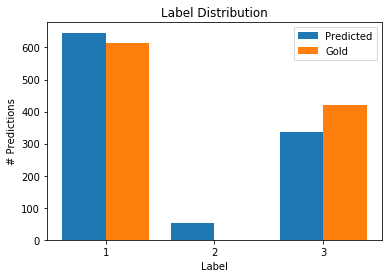

In [82]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)

Y_train_ps = label_model.predict_proba(LF_matrix)
Y_snorkel = label_model.predict(LF_matrix)
np.save("../data/interim/snorkel_proba", Y_train_ps)

plot_predictions_histogram(gold_standard,
                           label_model.predict(LF_matrix),
                           title="Label Distribution")

In [11]:
false = np.where(Y_snorkel != df['class'])
false_negatives = [x for x in false[0] if df['class'][x] == 2]
#false_positives = [x for x in false[0] if df['class'][x] == 3] # TRUE: Neutral, PRED: Incentive

In [ ]:
f_to_p = []
for x in false_negatives:
    print(x, df['sentences'][x], df['class'][x], Y_snorkel[x])

## Apply label model to unlabeled samples to generate noisy labels

In [83]:
noisy_kenya = pd.read_csv("../data/processed/kenya_raw.csv")
noisy_malawi = pd.read_csv("../data/processed/malawi_raw.csv")
noisy_india = pd.read_csv("../data/processed/india_raw.csv")

In [84]:
noisy_kenya['country'] = 'Kenya'
noisy_malawi['country'] = 'Malawi'
noisy_india['country'] = 'India'

In [85]:
all_raw = pd.concat((noisy_kenya, noisy_malawi))
all_raw = pd.concat((all_raw, noisy_india))
all_raw.to_csv("../data/processed/noisy.csv")

In [86]:
noisy_matrix = make_Ls_matrix(all_raw['sentences'], LFs)
noisy_matrix = noisy_matrix.astype(int)

KeyboardInterrupt: 

In [24]:
noisy_proba = label_model.predict_proba(noisy_matrix)
np.save("../data/interim/snorkel_noisy_proba", noisy_proba)